<a href="https://colab.research.google.com/github/raishwarya-16/cuadvancelab.github.io/blob/main/lab3_adversarial_attack_cs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attack on Cyberharassment Models

In lab 3 (Adversarial attack on cyberharassment models), you will add noise to the input of a cyberharassment model to make the model misclassify the input. This lab will walk you through this and will develop your intuition about adversarial attacks in AI models.

**You will learn:**
- How adversarial attack is generally structured
- How to attack an existing model
- Adversarial attack algorithms
- How to create a custom dataset loader in PyTorch and how to use a simple API that will do the same


## Required modules
First, run the cells below to import important packages needed for this lab. The second cell mounts Google drive which is where some files required for the lab will be stored. You will be prompted for authentication, please follow the instruction to authenticate.
- [numpy](https://www.numpy.org/) a Python package for scientific computing.
- [matplotlib](http://matplotlib.org) a Python library for visualization
- [PIL](http://www.pythonware.com/products/pil/) a Python package for image processing
- [torch](https://pytorch.org/) a Python open source source framework for deep learning


In [50]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os

# Set a seed for unified output
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Lab Overview

You are given a model that have been trained (pretrained) to detect not safe for work (NSFW) images. You are
also given a set pf NSFW test images. Of course building such models are important but as you will see in the
lab, such a model can be fooled to not detect such contents.

You will use adversarial algorithms to generate noise that will be added to the test images. When this modified
test image is passed through the model, the model will classify it as not NSFW even though it is.

## Data

We will use some NSFW images obtained by downloading images using the [ nsfw_data_scrapper](https://github.com/EBazarov/nsfw_data_source_urls). Each image belong to 1 of 5 categories (neutral, hentai, drawings, porn and sexy). Each of the categories will be a folder containing images that belong to that category.

Let us explore the test dataset. Download the data by running the cell below.

In [51]:
# Download the dataset
if not Path('test').is_dir():
    !wget https://buffalo.box.com/shared/static/x1wqhcvq46ux4uwlzd3df3uy1qh1n87h.zip
    # Unzip it
    !unzip -q x1wqhcvq46ux4uwlzd3df3uy1qh1n87h.zip -d test/

Let us first use a custom dataset class to explore our dataset. After running the cell above, the category folders with the images were stored in a 'test' folder in your google drive. The code below retrieves an image from the category folders in 'test'.

In [52]:
class CustomImageDataset(Dataset):
    def __init__(self, image_directory, image_transform=None, label_transform=None):
        """
        Generate a single example and its label from image_directory
        Args:
            image_directory (String): The parent directory containing the directory that the images reside
            image_transform (NoneType): Transformation to apply to the image, defaults to None
            label_transform (NoneType): Transformation to apply to the image labels, defaults to None
        Retruns:
            example (Tuple): A tuple of tensors - image and label
        """

        if not os.path.exists(image_directory):
            raise ValueError(f"Input file {image_directory} does not exist")

        self.image_directory = image_directory
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.img_labels = []
        self.classes = ['drawings', 'hentai', 'neutral', 'sexy']

        for category in self.classes:
            # if not os.path.exists(self.image_directory + '/' + category):
            #       os.makedirs(self.image_directory + '/' + category)
            files = os.listdir(self.image_directory + '/' + category)
            # Create a list of (image name, class folder) tuples
            self.img_labels.extend([(img_file, category) for img_file in files])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        # Read the image by getting its path: parent_directory/class/<name>.png
        image_path = self.img_labels[index][1] + "/" + self.img_labels[index][0]
        path = os.path.join(self.image_directory, image_path)
        image = Image.open(path).convert('RGB')
        label = self.classes.index(self.img_labels[index][1])

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        example = (image, label)

        return example

View the image at index 0 (the drawings category)





class = 0, which is drawings


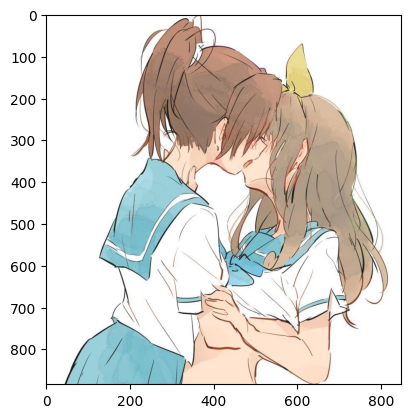

In [53]:
image_path = "/content/test"
test_data = CustomImageDataset(image_path,
                               image_transform=None,
                               label_transform=None)
index = 13
image, label = test_data[index]
plt.imshow(image)
print(f'class = {label}, which is {test_data.classes[label]}')


***
**<font color='red'>Task 1:</font>** Find the number of images there are in all category. <br> Don't access the attribute '\_\_len\_\_'. You can use the len function directly on the object of the CustomImageDataset class.
***


In [54]:
# Start code here #
total_number_of_images = len(test_data)
# End code here #

print(f"The number of images in the test dataset is: {total_number_of_images}")

The number of images in the test dataset is: 57


Now, use an built in PyTorch function to load the test dataset. We will use this built in function for the rest of this lab. Run the cells below to view an image.

Category/class map: {'drawings': 0, 'hentai': 1, 'neutral': 2, 'sexy': 3}
class = 0, which is drawings


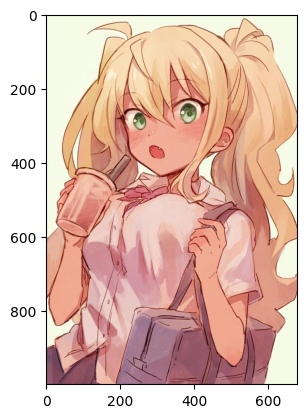

In [55]:
test_dataset = datasets.ImageFolder(image_path, transform=None)
class_dict = test_dataset.class_to_idx
print(f"Category/class map: {class_dict}")
idx_to_class = {}
for category, idx in class_dict.items():
    idx_to_class[idx] = category

index = 0
image, label = test_dataset[index]
plt.imshow(image)
print(f'class = {label}, which is {idx_to_class[label]}')

It is important to keep the dimension of all images the same, this allows to group a batch of images with the same shape into a single matrix/vector. We will perform some transformations on each image, for each image we make it a specific height and weight (224 x 224), center it, convert it to a tensor (converting the pixels into a vector) and normalize it. In this lab, we will batch our images into groups of 1 i.e each image is in its own batch.

In [56]:
image_path = "/content/test"
batch_size = 1
test_image_transforms = transforms.Compose([transforms.Resize(224),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(
                                                mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
                                        ])

dataset = datasets.ImageFolder(image_path, transform=test_image_transforms)
class_dict = dataset.class_to_idx
index_to_class = {}
for category, idx in class_dict.items():
    index_to_class[idx] = category

# Batch dataset and create an iterator over the dataset
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

***
**<font color='red'>Task 2:</font>**
- What is the size of an image and its label?
- What is the label index?
- What is the actual label (drawings, hentai, sexy, porn or neutral)?

Each image should be of the shape (batch size, # channels, height, weight). You can use the size() function to get the shape of a tensor and you can use the item() function to retrieve the element of a tensor.

Replace 'None' with the correct variable in the code below
***

In [57]:
classes =  list(class_dict.keys())
print(f"actual labels: {classes}")

# View one example
# Start code here #
for images, labels in test_dataloader:
    print(f"label index is: {labels[0].item()}")
    image_size = images[0].size()
    label_size = labels.size()
    label = classes[labels[0].item()]
    break
# End code here #

print(f"Image size: {image_size}, label size: {label_size} and class: {label}")

actual labels: ['drawings', 'hentai', 'neutral', 'sexy']
label index is: 2
Image size: torch.Size([3, 224, 224]), label size: torch.Size([1]) and class: neutral


## White-box Attack

In a white-box attack, the adversary (the agent generating the adversarial examples) have knowledge about the target model architecture, its parameters and training data. We will be performing a white-box attack since we have a model that have been trained to detect NSFW, we have access to its parameters and we know the data it was trained on.

Define the model architecture by running the cell below. Notice that in the **get_model()** function below, the last layer has 10 neurons instead of 5 (the NSFW classes). We do not know the reason why the original authors maintained the number of classes in the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Five would have been the natural number of neurons to use. However, observe that since the network have been trained on the NSFW dataset, the neuron with the highest probability will always be in the first five neurons.

In [58]:
def get_model():
    """
    Initialize the NSFW model which is a modified ResNet50 model with
    two additional fully-connected layers
    Args:
        None
    Returns:
        model (nn.Module): pre-trained NSFW model
    """

    # NSFW model uses ResNet50 with additional layers
    # Load ResNet50 model
    model = models.resnet50(pretrained=False)
    number_of_fully_connected_features = model.fc.in_features

    # Replacing last layer
    model.fc = nn.Sequential(
        nn.Linear(number_of_fully_connected_features, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 10),
        nn.LogSoftmax(dim=1)
    )

    return model


Download the model parameters (pre-trained weights) by running the cell below.
We will make use of a pretrained NSFW [model](https://github.com/emiliantolo/pytorch_nsfw_model).

In [59]:
if not os.path.isfile('ResNet50_nsfw_model.pth'):
    !wget https://github.com/emiliantolo/pytorch_nsfw_model/blob/master/ResNet50_nsfw_model.pth?raw=true -O ResNet50_nsfw_model.pth

Initialize the model and load its parameters

In [60]:
# Use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pre_trained_model_path = "/content/ResNet50_nsfw_model.pth"
# Initialize the network
model = get_model().to(device)

# Initialize the network with the pretrained weights (parameters that the previous model learned)
model.load_state_dict(torch.load(pre_trained_model_path, map_location='cpu'))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

## Attack
We will use fast gradient sign method (FGSM) to generate adversarial perturbations to fool the target model into predicting the wrong output.

Given an image $x$, FGSM generates an adversarial image $$x^{'} = x + ϵ * sign(∇_xJ(θ, x, l))$$

***
**<font color='red'>Task 3:</font>** Implement the FGSM formula in the code blow. Replace "None" with the formula.
***

Credit: The code in this section has been adapted from Nathan Inkawhich's work on adversarial example generation.

In [61]:
def fgsm(image, epsilon, data_grad):
    """
    Perform the FGSM attack on a single image
    Args:
        image (torch.tensor): The image to be perturbed
        epsilon (float): Hyperparameter for controlling the scale of perturbation
        data_grad (): The gradient of the loss wrt to image
    Returns:
        perturbed_image (torch.tensor): a perturbed image
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image

    # Start code here ~ 1 line of code #
    perturbed_image = image + epsilon * sign_data_grad
    # End code here #

    # Adding clipping to maintain [0,1] range
    if epsilon != 0.0:
        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

We will also use the projected gradient descent (PGD) method to generate adversarial examples.

Given a vectorized image $x$, PGD generates an adversarial image by
$$x^{'}_0 = x$$

> Repeat:
 $$x^{'}_{N+1} = Clip_x,_\epsilon \{x^{'}_N + \alpha * sign(∇_xJ(θ, x^{'}_N, l))\}$$

***
**<font color='red'>Task 4:</font>** Implement the PGD formula in the code blow. Replace "None" with the formula.
***

In [62]:
def pgd(model, image, label, epsilon, alpha, iterations):
    """
    Perform the PGD attack on an image
    Args:
        model (nn.Module): The NSFW model
        image (tensor): The images to be perturbed of shape [# channels, height, weight]
        label (tensor): The true labels of images of shape (1,)
        epsilon (float): Hyperparameter for controlling the scale of perturbation
        alpha (float): The step size i.e scale of the perturbation
        iterations (int): The number of iterations of images
    Returns:
        result (Tuple): A tuple of the perturbed image and the initial prediction for visualization purposes
    """

    image = image.to(device)
    label = label.to(device)
    original_image = image

    image.requires_grad = True
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    # If the initial prediction is wrong, dont bother attacking, just move on
    if init_pred.item() != label.item():
        return None, init_pred

    for i in range(iterations) :
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, label).to(device)
        loss.backward()

        sign_data_grad = image.grad.sign()

        # Start code here ~ 1 line of code #
        perturbed_image = image + alpha * sign_data_grad
        # End code here #

        # Perform clipping
        eta = torch.clamp(perturbed_image - original_image, min = -epsilon, max = epsilon)
        image = torch.clamp(original_image + eta, min = 0, max = 1).detach_()

    return image, init_pred

***
**<font color='red'>Task 5:</font>**
- Perform a forward pass through the model using the original image
- Perform an FGSM attack by using fgsm(...) function to generate an adversarial image
- Perform a forward pass through the model using the adversarial image
***

In [63]:
def fgsm_attack(model, test_dataloader, epsilon):
    """
    Performs the FGSM/PGD attack on a dataset given a specific epsilon value
    Args:
        model (nn.Module): The neural network under attack
        device (): put variables into cpu/gpu mode
        test_dataloader (DataLoader): an iterable over the dataset
        epsilon (float): hyperparameter for controlling the scale of perturbation
        attack_type (String): adversarial attack method, defaults to FGSM
    Returns:
        final_acc, adversarial_examples (Tuple): a tuple of the final accuracy
        of the attack and some adversarial examples for visualization
    """

    # We are not training, so set the model to evaluation mode
    model.eval()

    # Accuracy counter
    correct = 0
    adversarial_examples = []

    # Loop over all examples in test set
    for data, target in test_dataloader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model

        # Start code here ~ 1 line of code #
        output = model(data)
        # End code here #

        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM to add perturbation to the data

        # Start code here ~ 1 line of code #
        perturbed_data = fgsm(data, epsilon, data_grad)
        # End code here #

        # Re-classify the perturbed image

        # Start code here ~ 1 line of code #
        output = model(perturbed_data)
        # End code here #

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adversarial_examples) < 5):
                adversarial_example = perturbed_data.squeeze().detach().cpu().numpy()
                if (init_pred.item() == 0 and final_pred.item() == 0) or \
                   (init_pred.item() == 2 and final_pred.item() == 2):
                    adversarial_examples.append( (init_pred.item(), final_pred.item(), adversarial_example) )
        else:
            # Save some adversarial examples for visualization later
            if len(adversarial_examples) < 5:
                adversarial_example = perturbed_data.squeeze().detach().cpu().numpy()
                if (init_pred.item() == 0 and final_pred.item() == 0) or \
                (init_pred.item() == 0 and final_pred.item() == 2) or \
                (init_pred.item() == 2 and final_pred.item() == 0) or \
                (init_pred.item() == 2 and final_pred.item() == 1):
                    adversarial_examples.append( (init_pred.item(), final_pred.item(), adversarial_example) )

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_dataloader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataloader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adversarial_examples

***
**<font color='red'>Task 6:</font>**
- Perform an PGD attack by using the pgd(...) function to generate an adversarial image
- Perform a forward pass through the model using the adversarial image
***

In [64]:
def pgd_attack(model, test_dataloader, epsilon, alpha, iterations):
    """
    Performs the PGD attack on a dataset given a specific epsilon value
    Args:
        model (nn.Module): The neural network under attack
        device (): put variables into cpu/gpu mode
        test_dataloader (DataLoader): an iterable over the dataset
        epsilon (float): hyperparameter for controlling the scale of perturbation
        attack_type (String): adversarial attack method, defaults to FGSM
    Returns:
        final_acc, adversarial_examples (Tuple): a tuple of the final accuracy
        of the attack and some adversarial examples for visualization
    """

    # We are not training, so set the model to evaluation mode
    model.eval()

    # Accuracy counter
    correct = 0
    adversarial_examples = []

    # Loop over all examples in test set
    for data, target in test_dataloader:

        # Call PGD to add perturbation to the data

        # Start code here ~ 1 line #
        perturbed_data, init_pred = pgd(model, data, target, epsilon, alpha, iterations)
        # End code here #

        if perturbed_data is None: # Don't replace this None
            continue

        # Re-classify the perturbed image

        # Start code here ~ 1 line #
        output = model(perturbed_data)
        # End code here #

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adversarial_examples) < 5):
                adversarial_example = perturbed_data.squeeze().detach().cpu().numpy()
                if (init_pred.item() == 0 and final_pred.item() == 0) or \
                   (init_pred.item() == 2 and final_pred.item() == 2):
                    adversarial_examples.append( (init_pred.item(), final_pred.item(), adversarial_example) )
        else:
            # Save some adversarial examples for visualization later
            if len(adversarial_examples) < 5:
                adversarial_example = perturbed_data.squeeze().detach().cpu().numpy()
                if (init_pred.item() == 0 and final_pred.item() == 0) or \
                (init_pred.item() == 0 and final_pred.item() == 2) or \
                (init_pred.item() == 2 and final_pred.item() == 0) or \
                (init_pred.item() == 2 and final_pred.item() == 1):
                    adversarial_examples.append( (init_pred.item(), final_pred.item(), adversarial_example) )

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_dataloader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataloader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adversarial_examples

Visualization

In [65]:
def plot_accuracy_vs_epsilon(epsilons, accuracies):
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

In [66]:
# Plot several examples of adversarial samples at each epsilon. Note: Only showing images from the drawings and neutral classes to avoid showing inappropriate content
def plot_adversarial_samples(epsilons, adversarial_examples):
    count = 0

    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(adversarial_examples[i])):
            count += 1
            plt.subplot(len(epsilons),len(adversarial_examples[0]), count)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig, adv, ex = adversarial_examples[i][j]
            # Convert class indexes to string
            orig = index_to_class[orig]
            adv = index_to_class[adv]
            plt.title("{}\n -> {}".format(orig, adv))
            plt.imshow(np.transpose(ex, (1,2,0)), cmap="gray")
    plt.tight_layout()
    plt.show()

## Execute FGSM Attack

$ϵ$ controls the scale of the perturbations and we will use different $ϵ$ values to understand its effect.

***
**<font color='red'>Task 7:</font>**
- Replace the 'None' in the code below with the correct variables and perform FGSM attack by running the cells below.
- Describe your observations on the epsilons values
***

In [67]:
epsilons = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.14]

In [69]:
accuracies = []
adversarial_examples = []

# Perform attack using each epsilon value
# Start code here #
for eps in epsilons:
    accuracy, adversarial_example = fgsm_attack(model, test_dataloader, eps)
    accuracies.append(accuracy)
    adversarial_examples.append(adversarial_example)
# End code here #

Epsilon: 0.0	Test Accuracy = 36 / 57 = 0.631578947368421
Epsilon: 0.02	Test Accuracy = 24 / 57 = 0.42105263157894735
Epsilon: 0.04	Test Accuracy = 23 / 57 = 0.40350877192982454
Epsilon: 0.06	Test Accuracy = 23 / 57 = 0.40350877192982454
Epsilon: 0.08	Test Accuracy = 24 / 57 = 0.42105263157894735
Epsilon: 0.1	Test Accuracy = 24 / 57 = 0.42105263157894735
Epsilon: 0.14	Test Accuracy = 22 / 57 = 0.38596491228070173


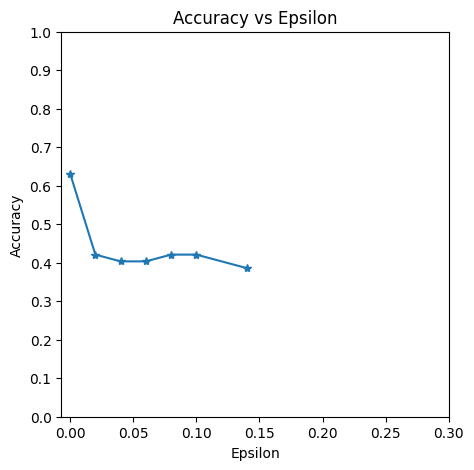

In [70]:
# Visualize accuracy vs epsilon
plot_accuracy_vs_epsilon(epsilons, accuracies)

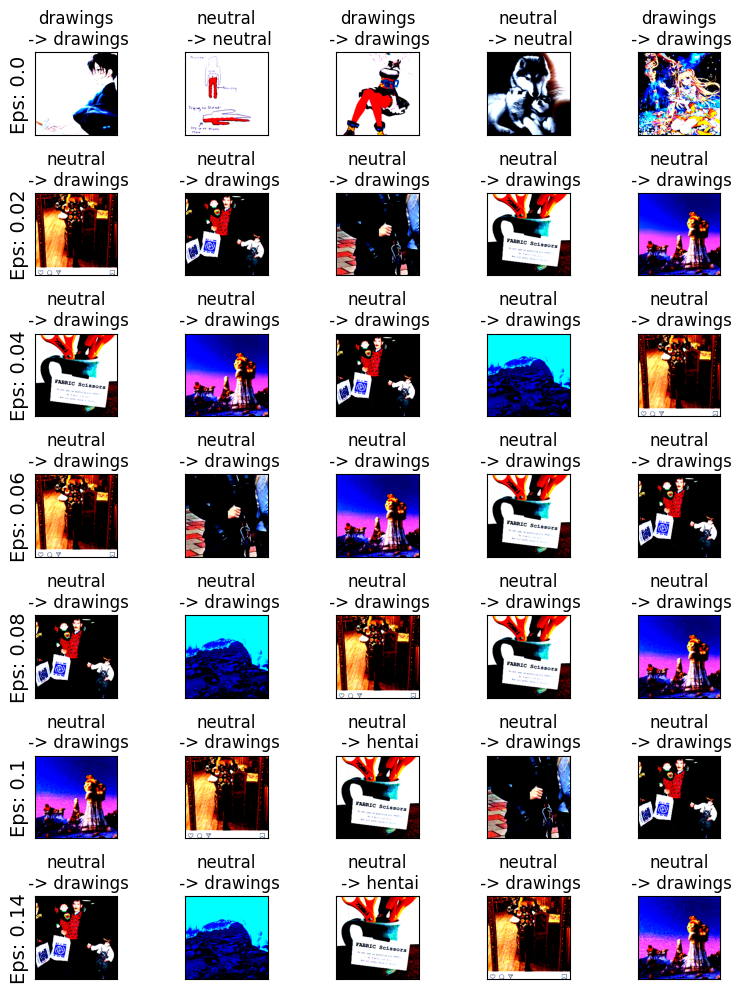

In [71]:
# Sample adversarial examples - Original prediction -> adversarial prediction
plot_adversarial_samples(epsilons, adversarial_examples)

## Execute PGD Attack

$α$ determines how much we change the pixel values, we will use different $α$ values to understand its effect.

***
**<font color='red'>Task 8:</font>**
- Replace the 'None' in the code below with the correct variables and perform PGD attack by completing and running the cells below. What are your observations?
***

In [72]:
epsilons = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.14]
iterations = 2
alpha = 1

In [73]:
accuracies = []
adversarial_examples = []

# Perform attack using each epsilon value
# Start code here #
for eps in epsilons:
    accuracy, adversarial_example = pgd_attack(model, test_dataloader, eps, alpha, iterations)
    accuracies.append(accuracy)
    adversarial_examples.append(adversarial_example)
# End code here #

Epsilon: 0.0	Test Accuracy = 26 / 57 = 0.45614035087719296
Epsilon: 0.02	Test Accuracy = 9 / 57 = 0.15789473684210525
Epsilon: 0.04	Test Accuracy = 7 / 57 = 0.12280701754385964
Epsilon: 0.06	Test Accuracy = 3 / 57 = 0.05263157894736842
Epsilon: 0.08	Test Accuracy = 3 / 57 = 0.05263157894736842
Epsilon: 0.1	Test Accuracy = 4 / 57 = 0.07017543859649122
Epsilon: 0.14	Test Accuracy = 4 / 57 = 0.07017543859649122


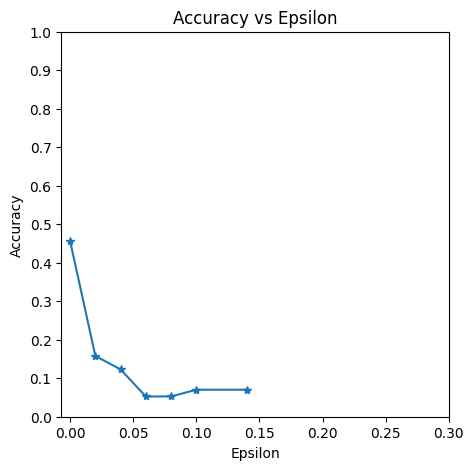

In [74]:
# Visualize accuracy vs epsilon
plot_accuracy_vs_epsilon(epsilons, accuracies)

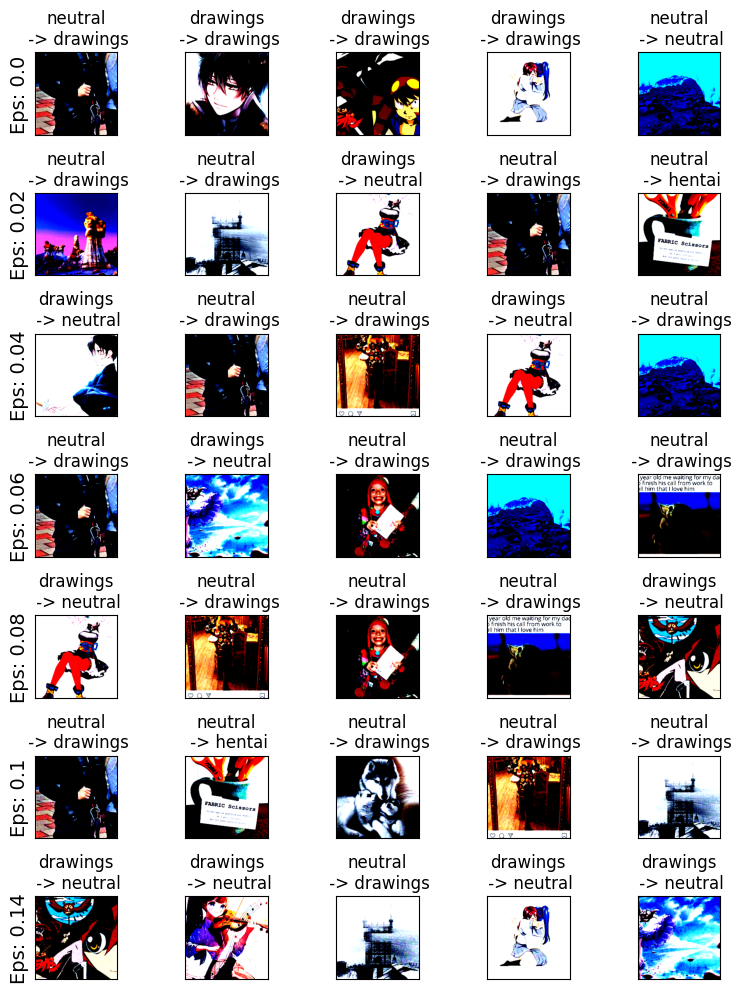

In [75]:
# Plot several examples of adversarial samples at each epsilon
plot_adversarial_samples(epsilons, adversarial_examples)